# Introduction

In this document, the technique that I used to generate a network of neurons which is spiking as a response to an external stimulation is presented. First, the neuron model and its biophysical properties are presented. Then, the method to measure the response of a single neuron of this type to an external stimulus is explained. At the end, a network is constructed and the results of its response to an external current is presented. All the simulations were performed using NEURON-7.4. Also the python code for running the simulation is provided.   

Neuron cell morphology was downloaded from Allen Brain Atlas: http://celltypes.brain-map.org/mouse/experiment/electrophysiology/314831019.
This cell has somatic, basal, apical and axonal branches. More specifically, it consists of a soma, axon, 27 apics and 53 dends. Using NEURON software, morphology of this cell was imported as a "swc" file format and was exported into the CellBuilder tool of NEURON software. Two main subsets were defined: 1) has_HH: which contained soma and axon, 2) no_HH: which contained dend and apic branches. In "has_HH" subset, active Hodgkin-Huxley current was inserted and a passive current was assigned to "no_HH" subset. Sodium, potassium and leak conductance in "has_HH" subset were 0.12, 0.036 and 0.0003(S/cm2) respectively. The passive conductance and leak reversal potential were 0.0002(S/cm2) and -65(mV). The rest of the cell properties were not changed from their default values. Finally, this cell was exported as a "hoc" file, called "myneuron.hoc" and a cell-type was assigned to this cell, called "Mycell". It was possible to use this cell as a template for running simulation. The following python code was implemented to import this file as a template to NEURON software. 

In [1]:
from matplotlib import pyplot
from matplotlib.pyplot import *
from neuron import h, gui
import numpy 

%matplotlib inline

In [2]:
h.load_file("myneuron.hoc") #Importing hoc file as a template 
cell1 = h.Mycell() #Mycell is the neuron class defined inside "myneuron.hoc"

#Studying single neuron response to an external current

In absence of any stimuli the membrane potential of the cell is generally constant (ranges between -40mV to -80mV). To understand the behavior of the cell under an external stimulation, a positive current Clamp was injected to the cell and the voltage across the membrane was recorded during this stimulation. Injection of the current into the cell, depolarizes the membrane and when the current is higher than a threshold, this depolarization generates a spike in the membrane voltage. To perform this experiment, the following function was defined which injects a current Clamp to a given cell. It is possible to assign a delay time for the starting of current injection. Also the duration and the amplitude of the current are adjustable. In this specific function, the current is injected to the middle of soma, however, it is possible to inject the current to other locations as well. This function is called "attach_current_clamp".

In [3]:
def attach_current_clamp(cell, delay, dur, amp):
    stim = h.IClamp(cell.soma(0.5))
    stim.delay = delay
    stim.dur = dur
    stim.amp = amp
    return stim

For recording the output, the following function, called "set_recording_vectors" was defined. Here, I set one recorder at the middle of soma to record the membrane voltage versus time. Also a function called "show_output" is defined for plotting the results.

In [4]:
# Function for recording the output
def set_recording_vectors(cell):
    soma_v_vec = h.Vector()   # Membrane potential vector at soma
    t_vec = h.Vector()        # Time stamp vector
    soma_v_vec.record(cell.soma(0.5)._ref_v)
    t_vec.record(h._ref_t)
    return soma_v_vec, t_vec

# Function for plotting the output    
def show_output(soma_v_vec, t_vec, new_fig=True, legend=None):
    if new_fig:
        pyplot.figure(figsize=(10,5)) # Default figsize is (8,6)
    soma_plot = pyplot.plot(t_vec, soma_v_vec, color='black')
    
    if legend is not None:
        pyplot.legend(soma_plot, [legend])
    pyplot.xlabel('time (ms)')
    pyplot.ylabel('mV')

Finally, a function for running the simulation and setting the simulation time was implemented.

In [5]:
def simulate(tstop=25):
    h.tstop = tstop
    h.run()

Now we are ready to inject an external current to cell1(which was copied from the template at the beginning of this code). In the following code, the amplitude of the current was changed between 0.1 to 1nA. This was done in an attempt to find the threshold, for which the spike in the output voltage of membrane happens. 

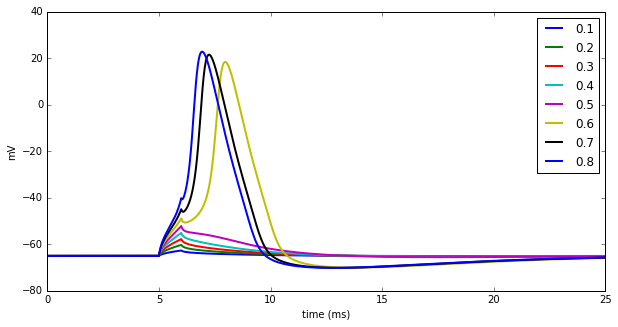

In [6]:
step = 0.1
num_steps = 8
pyplot.figure(figsize=(10,5))

for i in numpy.linspace(step, step*num_steps, num_steps):
    stim = attach_current_clamp(cell1, 5, 1, i )
    soma_v_vec, t_vec = set_recording_vectors(cell1)
    simulate(25)
    pyplot.plot(t_vec, soma_v_vec, label=i,linewidth=2)
    pyplot.xlabel('time (ms)')
    pyplot.ylabel('mV')
    
pyplot.legend()
pyplot.show()

As it is clear from the figure above, the threshold for current amplitude to trigger a spike in the output voltage is between 0.5-0.6nA. This experiment demonstrated how this cell responds to an external current. Now we would like to generate a network from this cell and measure its response to an external stimulation. 

# Building a network
To build a network, I generated multiple copies of the same cell using the template as the following:

In [7]:
N=2
cells = [h.Mycell() for i in range(N)]
# distance between them is 100 microns along x 
cells[0].x =0 
cells[1].x = 100

Now we stimulate cell1 and measure the membrane voltage on all cells.

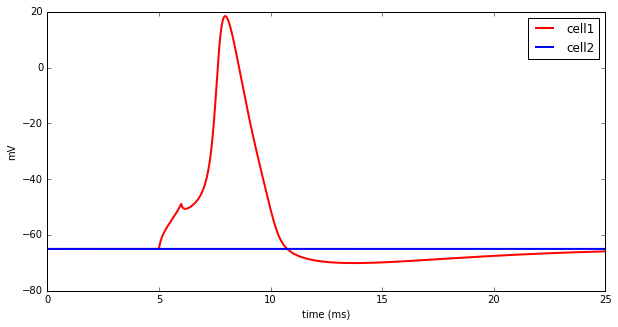

In [8]:
stim = attach_current_clamp(cells[0], 5, 1, 0.6 )
labels = ['cell' + str(i+1) for i in range(N)]
colors = ['red', 'blue']
pyplot.figure(figsize=(10,5))

for i in range(N):
    soma_v_vec, t_vec = set_recording_vectors(cells[i])
    simulate(25)
    pyplot.plot(t_vec, soma_v_vec, label=labels[i], color=colors[i],linewidth=2)
    pyplot.xlabel('time (ms)')
    pyplot.ylabel('mV')

pyplot.legend()
pyplot.show()

It is clear from the figure above that only first cell is responding to the external current. This is not surprising because these cells are not connected. In order to connect these two cells, synaptic junction was defined between two cells. I used an excitatory synapse (ExpSyn) in which an action potential in a presynaptic neuron increases the probability of an action potential occurring in a postsynaptic cell. If I generate a closed loop of neurons, connected together with excitatory synapses, neurons will spike repeatedly, one after the other and this will propagate through the network and will continue. This means that with stimulating the first neuron, the action potential will travel through synapse to other neurons and this will continue in the network. 

In [9]:
# This synapse is connecting the soma of the first cell
# to the first dendrite of the second cell
syn1 = h.ExpSyn(cells[1].dend[0](0.5))
nc1  = h.NetCon(cells[0].soma(0.5)._ref_v, syn1, sec=cells[0].soma)
nc1.weight[0] = 1
nc1.delay = 10

# This synapse is connecting the soma of the second cell 
# to the first dendrite of first cell 
syn2 = h.ExpSyn(cells[0].dend[0](0.5))
nc2  = h.NetCon(cells[1].soma(0.5)._ref_v, syn2, sec=cells[1].soma)
nc2.weight[0] = 1
nc2.delay = 10

# Studying network response to an external current
Now, lets stimulate cell1 and measure the output voltage of all the other cells.


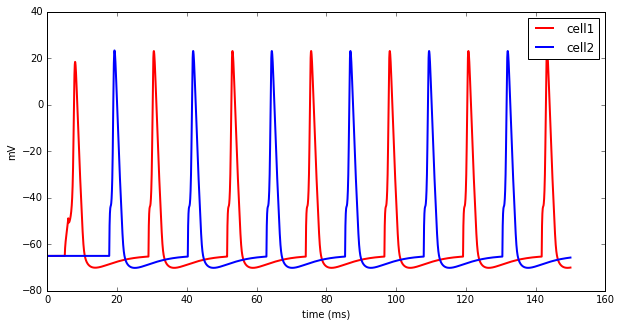

In [10]:
stim = attach_current_clamp(cells[0], 5, 1, 0.6 )
labels = ['cell' + str(i+1) for i in range(N)]
colors = ['red', 'blue']

pyplot.figure(figsize=(10,5))

for i in range(N):
    soma_v_vec, t_vec = set_recording_vectors(cells[i])
    simulate(150)
    pyplot.plot(t_vec, soma_v_vec, label=labels[i], color=colors[i],linewidth=2)
    pyplot.xlabel('time (ms)')
    pyplot.ylabel('mV')

pyplot.legend()
pyplot.show()

The figure above shows that first cell spikes after 5ms of injecting current Clamp, Then this spike travels to second cell and it triggers another spike in second cell after 10ms (defined in the code above). Spike generated in second cell, travels back to the first cell and so on.
In the following, we studied a network of 3 neurons.

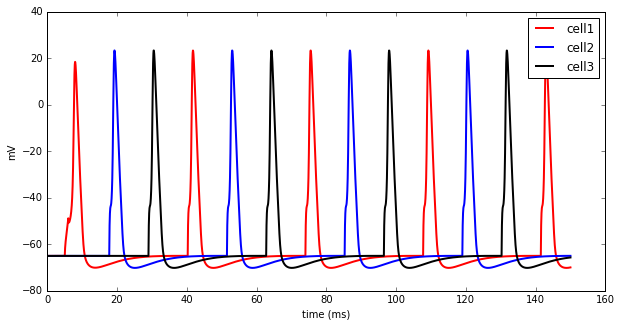

In [11]:
N=3
cells = [h.Mycell() for i in range(N)]
cells[0].x =0 
cells[1].x = 100
cells[2].x = 200

stim = attach_current_clamp(cells[0], 5, 1, 0.6 )

syn1 = h.ExpSyn(cells[1].dend[0](0.5))
nc1  = h.NetCon(cells[0].soma(0.5)._ref_v, syn1, sec=cells[0].soma)
nc1.weight[0] = 1
nc1.delay = 10

syn2 = h.ExpSyn(cells[2].dend[0](0.5))
nc2  = h.NetCon(cells[1].soma(0.5)._ref_v, syn2, sec=cells[1].soma)
nc2.weight[0] = 1
nc2.delay = 10

syn3 = h.ExpSyn(cells[0].dend[0](0.5))
nc3  = h.NetCon(cells[2].soma(0.5)._ref_v, syn3, sec=cells[2].soma)
nc3.weight[0] = 1
nc3.delay = 10

labels = ['cell' + str(i+1) for i in range(N)]
pyplot.figure(figsize=(10,5))
colors = ['red', 'blue','black']


for i in range(N):
    soma_v_vec, t_vec = set_recording_vectors(cells[i])
    simulate(150)
    pyplot.plot(t_vec, soma_v_vec, label=labels[i], color=colors[i],linewidth=2)
    pyplot.xlabel('time (ms)')
    pyplot.ylabel('mV')

pyplot.legend()
pyplot.show()

As it is clear from the figure above, presence of excitatory synapses allows the signal generated in the first cell to travel to other cells. In order to show more clearly how these neurons fire one after the other, below, I presented a plot which shows when each neuron spikes and how long each spike last. 

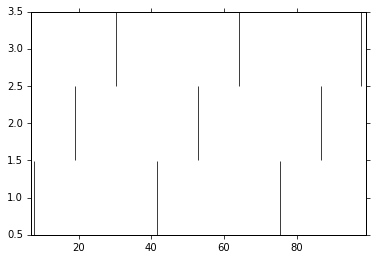

In [12]:
t_vec = h.Vector()
id_vec = h.Vector()
nclist = [nc1,nc2,nc3]
for i in range(len(nclist)):
    nclist[i].record(t_vec, id_vec, i)

simulate(tstop=100)

from neuronpy.graphics import spikeplot
from neuronpy.util import spiketrain

spikes = spiketrain.netconvecs_to_listoflists(t_vec, id_vec)
sp = spikeplot.SpikePlot(savefig=True)
sp.plot_spikes(spikes)

# Summary

In this document, combining NEURON and python, I presented a technique that I used to generate a network from one cell-type. Also, the code implementation and results of a current Clamp experiment on a single cell and on a network are provided. Results show that the single cell fires when the current amplitude is more than a threshold. In a network, if the cells are connected to each other with excitatory synapses, this spike can travel from one cell to another cell and continues in the network.  